In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from pyfmax import fmax
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection
from metric_tools import *
from scipy.spatial import distance

%matplotlib inline
sns.set(style="white", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
# load feature table into DF
table_file = '%s/tables/HiTS_training_set_goodP.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('ID')
print label_samp.shape

(8836, 74)


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
label_samp.Var_Type.value_counts()

NV        5000
QSO       3495
RRLYR      134
CV          94
EB          87
SNe         12
MISC         7
ROTVAR       5
DSCT         1
LPV          1
Name: Var_Type, dtype: int64

In [4]:
label_samp.head()

,internalID,raMedian,decMedian,X,Y,spCl,spSubCl,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
ID,,,,,,,,,,,,,,,,,,,,,
HiTS104506-002747,Blind14A_19_N19_1720_3738,161.278461,-0.463066,1720.768139,3738.788840,GALAXY,STARBURST,NV,NaN,0.009567,...,0.230762,-0.035108,0.091238,-1.084781,0.006477,0.866802,0.685588,NaN,NaN,NaN
HiTS104445+022013,Blind14A_20_S9_1104_2980,161.189658,2.337103,1104.247578,2980.433586,GALAXY,NaN,NV,NaN,0.012085,...,0.228233,0.193119,0.091244,-0.700074,0.006947,0.846997,0.767762,NaN,NaN,NaN
HiTS105721+020221,Blind14A_21_N5_0662_2268,164.337947,2.039295,662.979512,2268.392342,GALAXY,STARFORMING,NV,NaN,0.017333,...,0.197445,-0.521790,0.091252,0.061091,0.009662,0.828883,0.747913,NaN,NaN,NaN
HiTS105333-000140,Blind14A_22_N6_0262_1631,163.390026,-0.027815,262.340695,1631.238769,GALAXY,NaN,NV,NaN,0.012767,...,0.201758,0.390108,0.091211,0.132114,0.006689,0.844004,0.775294,NaN,NaN,NaN
HiTS105408-000110,Blind14A_22_N6_0149_3637,163.536410,-0.019643,149.334465,3637.366747,GALAXY,AGN,NV,NaN,0.017250,...,0.253608,-0.318484,0.091211,-0.066405,0.009455,0.831285,0.769587,NaN,NaN,NaN


In [5]:
print 'original shape:', label_samp.shape
cols = label_samp.columns.values
FATS_feats_all = cols[9:]
FATS_feats_non = cols[9:-3]
label_samp_non = label_samp.dropna(subset=FATS_feats_non)

original shape: (8836, 74)


In [6]:
print label_samp_non.shape
print label_samp_non.Var_Type.value_counts()

(8836, 74)
NV        5000
QSO       3495
RRLYR      134
CV          94
EB          87
SNe         12
MISC         7
ROTVAR       5
DSCT         1
LPV          1
Name: Var_Type, dtype: int64


### Negative part

In [13]:
negative = pd.read_csv('%s/tables/HiTS_training_set_goodP_negpart.csv'\
              %(mainpath))
negative.set_index('ID', inplace=True)
FATS_feats_non_neg = negative.columns.values[:-1]
print FATS_feats_non_neg

['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_sigma_negpart' 'CAR_tau' 'Con' 'Eta_e'
 'FluxPercentileRatioMid20' 'FluxPercentileRatioMid35'
 'FluxPercentileRatioMid50' 'FluxPercentileRatioMid65'
 'FluxPercentileRatioMid80' 'Freq1_harmonics_amplitude_0'
 'Freq1_harmonics_amplitude_1' 'Freq1_harmonics_amplitude_2'
 'Freq1_harmonics_amplitude_3' 'Freq1_harmonics_rel_phase_0'
 'Freq1_harmonics_rel_phase_1' 'Freq1_harmonics_rel_phase_1_negpart'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_2_negpart'
 'Freq1_harmonics_rel_phase_3' 'Freq1_harmonics_rel_phase_3_negpart'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_1_negpart' 'Freq2_harmonics_rel_phase_2'
 'Freq2_harmonics_rel_phase_2_negpart' 'Freq2_harmonics_rel_phase_3'
 'Freq2_harmonics_rel_phase_3_negpart' 'Freq3_harmoni

### pyFmax

In [8]:
# convert string labels to int values
def label_str_to_int(label):
    label_int = np.zeros(label.shape, dtype = int)
    print label_int.shape
    classes = set(label)
    class_dict = {}
    for k, cl in enumerate(classes):
        class_dict[k] = cl
        mask = label == cl
        print label_int[mask].shape
        label_int[mask] = k

    return label_int, class_dict

In [9]:
label, d = label_str_to_int(label_samp.Var_Type.values)
print d
print label

(8836,)
(12,)
(7,)
(1,)
(1,)
(3495,)
(87,)
(5,)
(134,)
(94,)
(5000,)
{0: 'SNe', 1: 'MISC', 2: 'LPV', 3: 'DSCT', 4: 'QSO', 5: 'EB', 6: 'ROTVAR', 7: 'RRLYR', 8: 'CV', 9: 'NV'}
[9 9 9 ..., 9 9 9]


In [14]:
obj = fmax.MatrixClustered(negative[FATS_feats_non_neg].values, label, labels_col=FATS_feats_non_neg)

In [15]:
for idx, list_features in enumerate(obj.get_features_selected()):
    print "Feature selected for cluster ", d[idx]
    for f in list_features:
        print '\t', obj.get_col_label(f)

Feature selected for cluster  SNe
Feature selected for cluster  MISC
Feature selected for cluster  LPV
Feature selected for cluster  DSCT
Feature selected for cluster  QSO
	CAR_tau
Feature selected for cluster  EB
	CAR_mean
	Eta_e
Feature selected for cluster  ROTVAR
	PeriodLS
Feature selected for cluster  RRLYR
	Autocor_length
	CAR_sigma
	Eta_e
	MaxSlope
	Mean
Feature selected for cluster  CV
Feature selected for cluster  NV
	AndersonDarling
	Autocor_length
	Beyond1Std
	CAR_mean
	Eta_e
	FluxPercentileRatioMid50
	FluxPercentileRatioMid65
	FluxPercentileRatioMid80
	Freq1_harmonics_rel_phase_1
	Freq1_harmonics_rel_phase_1_negpart
	Freq1_harmonics_rel_phase_2
	Freq1_harmonics_rel_phase_2_negpart
	Freq1_harmonics_rel_phase_3
	Freq1_harmonics_rel_phase_3_negpart
	Freq2_harmonics_rel_phase_1
	Freq2_harmonics_rel_phase_1_negpart
	Freq2_harmonics_rel_phase_2
	Freq2_harmonics_rel_phase_2_negpart
	Freq2_harmonics_rel_phase_3
	Freq2_harmonics_rel_phase_3_negpart
	Freq3_harmonics_rel_phase_1
	Freq

In [16]:
print "Features selected for the whole data:"
selected_feats = FATS_feats_non_neg[list(obj.get_features_selected_flat())]
print selected_feats

Features selected for the whole data:
['AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma'
 'CAR_tau' 'Eta_e' 'FluxPercentileRatioMid50' 'FluxPercentileRatioMid65'
 'FluxPercentileRatioMid80' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_1_negpart' 'Freq1_harmonics_rel_phase_2'
 'Freq1_harmonics_rel_phase_2_negpart' 'Freq1_harmonics_rel_phase_3'
 'Freq1_harmonics_rel_phase_3_negpart' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_1_negpart' 'Freq2_harmonics_rel_phase_2'
 'Freq2_harmonics_rel_phase_2_negpart' 'Freq2_harmonics_rel_phase_3'
 'Freq2_harmonics_rel_phase_3_negpart' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_1_negpart' 'Freq3_harmonics_rel_phase_2'
 'Freq3_harmonics_rel_phase_2_negpart' 'Freq3_harmonics_rel_phase_3'
 'Freq3_harmonics_rel_phase_3_negpart' 'MaxSlope' 'Mean' 'MedianBRP'
 'PeriodGLS' 'PeriodLS' 'Period_fit' 'Psi_eta' 'SmallKurtosis' 'StetsonK'
 'StetsonK_AC']


In [30]:
contrast_matrix = pd.DataFrame()
for l in set(label):
    print d[l]
    for f, feat in enumerate(FATS_feats_non_neg):
        print '\r', feat,
        contrast_matrix.loc[d[l],feat] = obj.contrast(f, l)
    print '\r',
contrast_matrix.fillna(1, inplace=True)
contrast_matrix
contrast_matrix.to_csv('%s/tables/Contrast_matrix_HiTS_TS_negpart.csv'\
              %(mainpath))

SNe
MISC
LPV
DSCT
QSO
EB
ROTVAR
RRLYR
CV
NV


In [31]:
contrast_matrix

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_sigma_negpart,CAR_tau,Con,Eta_e,...,Q31,Rcs,Skew,Skew_negpart,SlottedA_length,SmallKurtosis,SmallKurtosis_negpart,Std,StetsonK,StetsonK_AC
SNe,0.000237,0.000059,0.000184,0.000051,0.000014,0.000031,2.250080e-05,4.866739e-01,0.0,0.004134,...,0.000162,0.000081,0.000054,0.000054,0.000051,0.000048,0.000049,0.000195,0.000054,0.000056
MISC,0.000031,0.000030,0.000038,0.000026,0.000061,0.000030,9.132667e-07,4.952149e-01,0.0,0.001540,...,0.000025,0.000030,0.000081,0.000018,0.000011,0.000060,0.000019,0.000027,0.000030,0.000032
LPV,0.577596,0.345152,0.518467,0.427898,0.000011,0.000000,3.024043e-01,2.560404e-08,0.0,0.000654,...,0.661037,1.097453,0.000000,1.765203,4.520439,0.000000,0.494803,0.892934,0.211996,0.231413
DSCT,0.390357,0.182608,0.083662,0.077890,0.050393,0.000000,4.817149e+00,4.991857e-12,0.0,0.063069,...,0.332266,0.157038,0.000000,0.704038,0.062058,0.109044,0.000000,0.386239,0.123183,0.131649
QSO,0.000421,0.000436,0.000436,0.000368,0.005480,0.000073,2.078107e-04,8.927030e+00,10.0,0.005124,...,0.000249,0.000414,0.000846,0.000229,0.000161,0.000964,0.000126,0.000329,0.000450,0.000430
EB,0.601828,0.431685,0.297832,0.334992,3.072627,2.074071,9.511708e-01,6.643609e-09,0.0,3.622741,...,0.601913,0.210478,0.877552,0.040460,0.118323,0.102747,0.643100,0.580463,0.347229,0.358181
ROTVAR,0.663703,0.580489,0.900815,0.535275,0.101508,0.791571,1.779717e+00,1.647432e-08,0.0,0.178762,...,0.749644,0.589227,0.979007,0.251242,1.438383,0.000000,1.171412,0.663014,0.404632,0.433479
RRLYR,6.967229,2.550231,1.916289,2.285077,0.742257,7.084787,1.973931e+00,2.219456e-08,0.0,2.986221,...,7.133264,1.532111,0.206675,2.887037,0.923936,0.439029,4.140318,6.852382,1.947551,2.037309
CV,0.003380,0.002208,0.002199,0.001861,0.030973,0.001017,1.836599e-03,9.107560e-02,0.0,0.024860,...,0.002096,0.001972,0.004260,0.001281,0.000949,0.005288,0.000530,0.002761,0.002261,0.002152
NV,0.795218,5.907102,6.280077,6.336561,5.996677,0.048420,1.735599e-01,5.087706e-06,0.0,3.112896,...,0.519344,6.411196,7.931526,4.350436,2.935690,9.342820,3.549644,0.621656,6.962615,6.805300


In [32]:
trans_matrix_my = pd.read_csv('%s/tables/HiTS_TS_negpart_contrasted.csv'\
              %(mainpath))
trans_matrix_my.set_index('ID', inplace=True)
trans_matrix_my.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_sigma_negpart,CAR_tau,Con,Eta_e,...,Rcs,Skew,Skew_negpart,SlottedA_length,SmallKurtosis,SmallKurtosis_negpart,Std,StetsonK,StetsonK_AC,Var_Type
ID,,,,,,,,,,,,,,,,,,,,,
HiTS104506-002747,0.007608,4.709874,6.280077,2.851453,180.265651,0.000000e+00,9.464216e-11,3.027178e-06,0.0,24.895153,...,1.479458,0.000000,0.152734,0.267845,0.000000,3.850586,0.004027,6.035207,4.665636,NV
HiTS104445+022013,0.009610,3.249882,6.280077,1.900968,178.672544,2.207580e-11,0.000000e+00,3.027353e-06,0.0,20.579013,...,1.463244,1.531729,0.000000,0.267863,0.000000,2.485014,0.004319,5.897317,5.224852,NV
HiTS105721+020221,0.013784,3.176483,6.280077,1.584140,1074.969886,0.000000e+00,5.355007e-03,4.983958e-07,0.0,21.902827,...,1.265858,0.000000,2.270014,0.267888,0.570759,0.000000,0.006007,5.771194,5.089770,NV
HiTS105333-000140,0.010153,2.354135,6.280077,1.584140,181.714726,1.826007e-12,0.000000e+00,3.026991e-06,0.0,23.180840,...,1.293509,3.094151,0.000000,0.267767,1.234317,0.000000,0.004158,5.876475,5.276106,NV
HiTS105408-000110,0.013717,3.744424,6.280077,2.851453,2007.901553,0.000000e+00,5.715364e-03,2.728786e-07,0.0,19.986284,...,1.625929,0.000000,1.385546,0.267767,0.000000,0.235712,0.005878,5.787920,5.237272,NV


In [20]:
trans_matrix_my.Var_Type.value_counts()

NV        5000
QSO       3495
RRLYR      134
CV          94
EB          87
SNe         12
MISC         7
ROTVAR       5
DSCT         1
LPV          1
Name: Var_Type, dtype: int64

In [33]:
negative = negative[negative.Var_Type != 'DSCT']
negative = negative[negative.Var_Type != 'LPV']
trans_matrix_my = trans_matrix_my[trans_matrix_my.Var_Type != 'DSCT']
trans_matrix_my = trans_matrix_my[trans_matrix_my.Var_Type != 'LPV']

In [34]:
RFC = RandomForestClassifier(n_estimators=100, criterion='entropy',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced')
ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.)

## RF before Fmax 

In [35]:
scores_b = model_selection.cross_val_score(RFC, 
                        negative[FATS_feats_non_neg],
                        negative['Var_Type'], scoring='f1_macro', cv=ss,
                        n_jobs=2, verbose=1)

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   37.6s finished


In [36]:
clases_b = list(set(negative['Var_Type']))
prediction_b = model_selection.cross_val_predict(RFC, 
                        negative[FATS_feats_non_neg],
                        negative['Var_Type'], cv=4, n_jobs=2, verbose=1)

[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   22.6s finished


In [37]:
print "Accuracy = ", scores_b.mean(), "+-", scores_b.std()
print 'F1-score in test set: \t%f' % (metrics.f1_score(negative['Var_Type'],
                                    prediction_b,
                                    average='macro',labels=clases_b))
print metrics.classification_report(negative['Var_Type'], prediction_b)

Accuracy =  0.500964463045 +- 0.0515113163427
F1-score in test set: 	0.533139
             precision    recall  f1-score   support

         CV       0.00      0.00      0.00        94
         EB       0.89      0.92      0.90        87
       MISC       0.00      0.00      0.00         7
         NV       0.97      1.00      0.98      5000
        QSO       0.97      0.96      0.96      3495
     ROTVAR       0.00      0.00      0.00         5
      RRLYR       0.98      0.92      0.95       134
        SNe       0.80      0.33      0.47        12

avg / total       0.96      0.97      0.96      8834



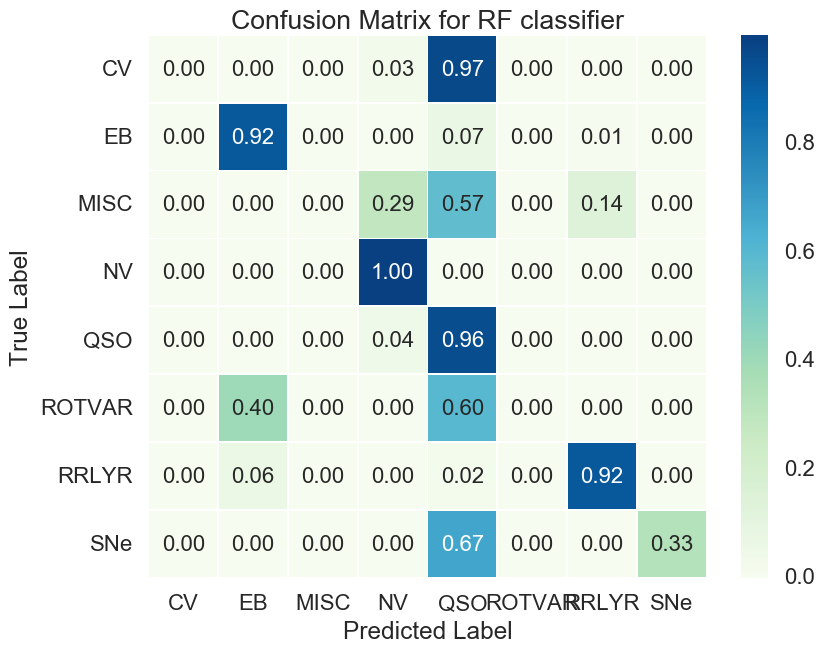

In [38]:
conf_matrix(negative['Var_Type'].values, prediction_b, clases_b,
            save=False, normalized=True)

## RF after Fmax

In [39]:
trans_matrix_my.columns

Index([u'Amplitude', u'AndersonDarling', u'Autocor_length', u'Beyond1Std',
       u'CAR_mean', u'CAR_sigma', u'CAR_sigma_negpart', u'CAR_tau', u'Con',
       u'Eta_e', u'FluxPercentileRatioMid20', u'FluxPercentileRatioMid35',
       u'FluxPercentileRatioMid50', u'FluxPercentileRatioMid65',
       u'FluxPercentileRatioMid80', u'Freq1_harmonics_amplitude_0',
       u'Freq1_harmonics_amplitude_1', u'Freq1_harmonics_amplitude_2',
       u'Freq1_harmonics_amplitude_3', u'Freq1_harmonics_rel_phase_0',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_1_negpart',
       u'Freq1_harmonics_rel_phase_2', u'Freq1_harmonics_rel_phase_2_negpart',
       u'Freq1_harmonics_rel_phase_3', u'Freq1_harmonics_rel_phase_3_negpart',
       u'Freq2_harmonics_amplitude_0', u'Freq2_harmonics_amplitude_1',
       u'Freq2_harmonics_amplitude_2', u'Freq2_harmonics_amplitude_3',
       u'Freq2_harmonics_rel_phase_0', u'Freq2_harmonics_rel_phase_1',
       u'Freq2_harmonics_rel_phase_1_negpart', u'

In [40]:
scores_a = model_selection.cross_val_score(RFC, 
                        trans_matrix_my[selected_feats],
                        trans_matrix_my['Var_Type'], scoring='f1_macro', cv=ss,
                        n_jobs=2, verbose=1)

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   13.8s finished


In [41]:
clases_a = list(set(trans_matrix_my['Var_Type']))
prediction_a = model_selection.cross_val_predict(RFC, 
                        trans_matrix_my[selected_feats],
                        trans_matrix_my['Var_Type'], cv=3, n_jobs=2, verbose=1)

[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    3.5s finished


In [42]:
print "Accuracy = ", scores_a.mean(), "+-", scores_a.std()
print 'F1-score in test set: \t%f' % (metrics.f1_score(trans_matrix_my['Var_Type'],
                                    prediction_a, average='weighted',labels=clases_a))
print metrics.classification_report(trans_matrix_my['Var_Type'], prediction_a)

Accuracy =  0.973013803277 +- 0.0523339614719
F1-score in test set: 	0.999775
             precision    recall  f1-score   support

         CV       0.98      1.00      0.99        94
         EB       1.00      1.00      1.00        87
       MISC       1.00      1.00      1.00         7
         NV       1.00      1.00      1.00      5000
        QSO       1.00      1.00      1.00      3495
     ROTVAR       1.00      1.00      1.00         5
      RRLYR       1.00      1.00      1.00       134
        SNe       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00      8834



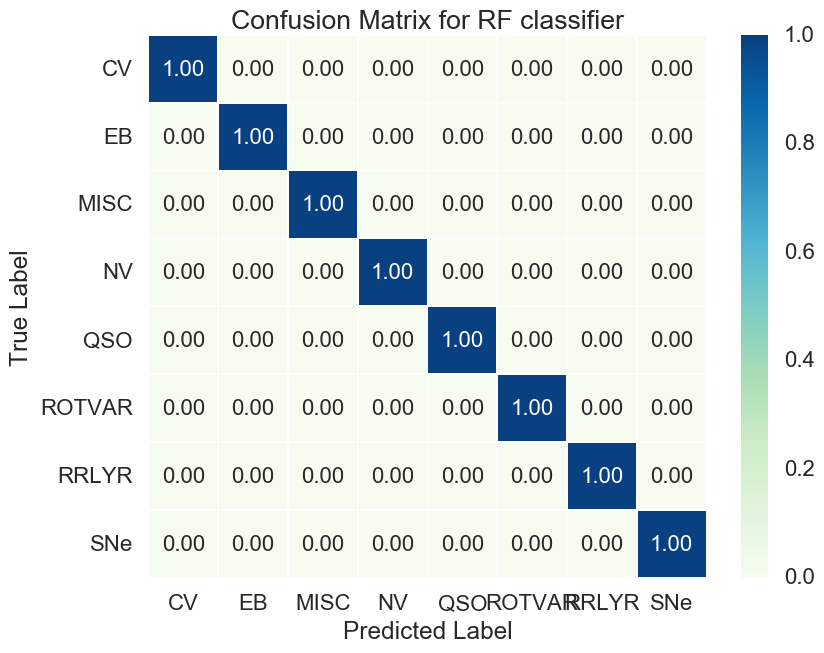

In [166]:
conf_matrix(trans_matrix_my['Var_Type'].values, prediction_a, clases_a,
            save=False, normalized=True)

## Apply Contrast matrix to unlabeled data

In [43]:
table_file = '%s/tables/Blind14A_U_Blind15A_all_labeled.csv'\
              %(mainpath)
target_set = pd.read_csv(table_file)
target_set = target_set.set_index('ID')

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
target_set_non = target_set.dropna(subset=FATS_feats_non)
target_set_non = target_set_non[target_set_non.Var_Type.isnull()]
target_set_non.sort_index(inplace=True)

In [47]:
negative_target = target_set_non
for i, feat in enumerate(FATS_feats_non):
    print feat
    if np.min(target_set_non[feat]) < 0:
        name = '%s_negpart' % (feat)
        mask = target_set_non[feat] < 0
        negative_target[name] = 0
        negative_target[name][mask] = np.absolute(negative_target[feat][mask])
        negative_target[feat][mask] = 0
negative_target = negative_target.reindex_axis(sorted(FATS_feats_non_neg), axis=1)
print FATS_feats_non_neg
negative_target.head()

Amplitude
AndersonDarling
Autocor_length
Beyond1Std
CAR_mean
CAR_sigma


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CAR_tau
Con
Eta_e
FluxPercentileRatioMid20
FluxPercentileRatioMid35
FluxPercentileRatioMid50
FluxPercentileRatioMid65
FluxPercentileRatioMid80
Freq1_harmonics_amplitude_0
Freq1_harmonics_amplitude_1
Freq1_harmonics_amplitude_2
Freq1_harmonics_amplitude_3
Freq1_harmonics_rel_phase_0
Freq1_harmonics_rel_phase_1
Freq1_harmonics_rel_phase_2
Freq1_harmonics_rel_phase_3
Freq2_harmonics_amplitude_0
Freq2_harmonics_amplitude_1
Freq2_harmonics_amplitude_2
Freq2_harmonics_amplitude_3
Freq2_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_1
Freq2_harmonics_rel_phase_2
Freq2_harmonics_rel_phase_3
Freq3_harmonics_amplitude_0
Freq3_harmonics_amplitude_1
Freq3_harmonics_amplitude_2
Freq3_harmonics_amplitude_3
Freq3_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_1
Freq3_harmonics_rel_phase_2
Freq3_harmonics_rel_phase_3
Gskew
LinearTrend
MaxSlope
Mean
Meanvariance
MedianAbsDev
MedianBRP
PairSlopeTrend
PercentAmplitude
PercentDifferenceFluxPercentile
PeriodGLS
PeriodLS
PeriodWMCC
Period_fit
Psi_CS
Psi_e

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_sigma_negpart,CAR_tau,Con,Eta_e,...,Q31,Rcs,Skew,Skew_negpart,SlottedA_length,SmallKurtosis,SmallKurtosis_negpart,Std,StetsonK,StetsonK_AC
ID,,,,,,,,,,,,,,,,,,,,,
HiTS090434-041626,0.137041,0.990836,1.0,0.277778,37.098579,2.500014e-08,0.0,0.594829,0.0,239.714254,...,0.045981,0.236113,0.919072,0.000000,0.067470,1.283156,0.000000,0.071872,0.753349,0.640374
HiTS090434-042338,0.296733,0.431611,1.0,0.318182,38.174904,4.312798e-08,0.0,0.594976,0.0,375.447959,...,0.180294,0.136189,0.068157,0.000000,0.067470,0.000000,0.181018,0.170818,0.788576,0.663841
HiTS090434-042506,0.343881,0.513946,1.0,0.250000,38.324069,3.789182e-09,0.0,0.594920,0.0,50.920220,...,0.206484,0.203633,0.637707,0.000000,0.067307,1.775557,0.000000,0.164192,0.871456,0.697903
HiTS090434-042629,0.354724,0.438666,1.0,0.347826,5997.307469,3.276984e+00,0.0,0.003783,0.0,397.180172,...,0.259289,0.205884,0.034033,0.000000,0.067470,0.083893,0.000000,0.200875,0.764079,0.629795
HiTS090435-000829,0.243364,0.497804,1.0,0.312500,37.786529,4.427833e-09,0.0,0.595192,0.0,48.073840,...,0.132013,0.208799,0.000000,0.614237,0.067314,0.996758,0.000000,0.122311,0.803396,0.792220


In [48]:
target_set[FATS_feats_non].head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC
ID,,,,,,,,,,,,,,,,,,,,,
HiTS090538-001905,0.078790,0.821859,1.0,0.200000,3442.933356,-6.082173e-01,0.005396,0.0,24.851688,0.200628,...,0.213533,1.523831,0.046881,0.215168,0.517676,0.067596,2.732353,0.041396,0.869189,0.707986
HiTS090525-002139,0.332484,0.915390,1.0,0.200000,37.141614,5.816486e-09,0.595292,0.0,31.281322,0.098607,...,0.260255,1.388065,0.122866,0.175526,0.687568,0.067594,2.302595,0.144356,0.732197,0.489923
HiTS090600-002143,0.344386,0.353682,1.0,0.238095,37.323343,-1.279760e-08,0.594700,0.0,49.880108,0.172360,...,0.243371,1.176367,0.202887,0.218243,-0.254095,0.067594,2.002224,0.182176,0.765451,0.724052
HiTS090631-002132,0.368528,1.000000,1.0,0.153846,58.694719,-3.504707e-01,0.337287,0.0,18.174025,0.061686,...,0.283545,1.306491,0.095793,0.191951,0.682832,0.067381,4.516568,0.162485,0.718453,0.557665
HiTS090652-001855,0.405756,0.733992,1.0,0.312500,12.563659,-7.439744e-02,1.783600,0.0,27.762594,0.244227,...,0.382961,1.064106,0.372507,0.336761,0.471259,0.067596,-0.063346,0.223462,0.897089,0.742705


In [49]:
negative_target_sample = negative_target.sample(1000)

In [57]:
contrasted_targe = pd.DataFrame()
dist = np.inf
print contrasted_targe
for l in set(label):
    aux = negative_target_sample.copy()
    for f, feat in enumerate(FATS_feats_non_neg):
        gain = contrast_matrix.loc[d[l], feat]
        aux.loc[:, feat] *= gain
    print '\r',
    dist_aux = distance.cdist(negative_target_sample, aux, metric='euclidean')
    det_dist_matrix = np.linalg.det(dist_aux)
    print det_dist_matrix
    if det_dist_matrix < dist:
        print 'hola'
        dist = det_dist_matrix
        contrasted_targe = aux

Empty DataFrame
Columns: []
Index: []
-0.0
hola
0.0
-0.0
0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
